# Examles of error propigation
Examples are taken from http://ipl.physics.harvard.edu/wp-uploads/2013/03/PS3_Error_Propagation_sp13.pdf and used on MCMC to show how the answers work

## Example 1

Example: suppose you measure the height H of a door and get 2.00 ± 0.03 m. This means that
H = 2.00 m and δH = 0.03 m. The door has a knob which is a height h = 0.88 ± 0.04 m from the bottom
of the door. Then the distance from the doorknob to the top of the door is Q = H − h = 1.12 m. What
is the uncertainty in Q?

Q = 1.12 ± 0.05 m


In [5]:
import numpy as np
import pymc3 as mc

In [17]:
model = mc.Model()

with model:

    H = mc.Normal('H', 2.00, tau=(0.03)**-2)
    h = mc.Normal('h', 0.88, tau=(0.04)**-2)
    Q = mc.Deterministic('Q', H-h)
    start = mc.find_MAP()
    trace = mc.sample(1e4, njobs=4, start=start)

    

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...


Optimization terminated successfully.
         Current function value: -4.887557
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1


Average Loss = 11.868:   5%|▍         | 9731/200000 [00:03<01:02, 3024.18it/s]
Convergence archived at 10000
Interrupted at 10,000 [5%]: Average Loss = 118.67
100%|██████████| 10500/10500.0 [00:10<00:00, 1022.66it/s]



H:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  2.000            0.030            0.000            [1.941, 2.059]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  1.941          1.980          2.000          2.020          2.059


h:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.880            0.040            0.000            [0.801, 0.958]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.802          0.853          0.880          0.906          0.959


Q:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------

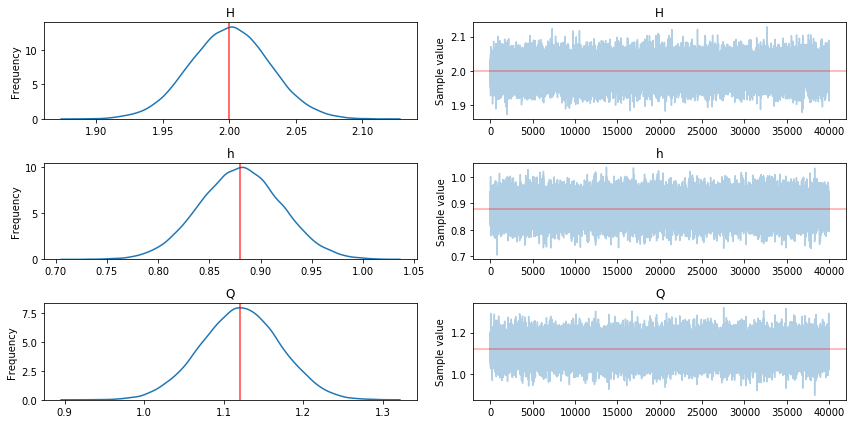

In [18]:
mc3.traceplot(trace, combined=True, lines={'H':2, 'h':0.88, 'Q':2-0.88})
mc3.summary(trace)
print("MCMC gives {0:.2f} +/- {1:.2f}, analytic gives {2} +/- {3}".format(trace['Q'].mean(), 
                                                                          trace['Q'].std(), 1.12, 0.05))

## Example 2

Example: a bird flies a distance d = 120 ± 3 m during a time t = 20.0 ± 1.2 s. The average speed of
the bird is v = d/t = 6 m/s. What is the uncertainty of v?

0.39 m/s.

In [27]:
with mc.Model() as model:
    d = mc.Normal('d', 123, tau=(3)**-2)
    t = mc.Normal('t', 20.0, tau=(1.2)**-2)
    v = mc.Deterministic('v', d/t)
    start = mc.find_MAP()
    trace = mc.sample(40000, njobs=4, start=start)

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...


Optimization terminated successfully.
         Current function value: 3.118811
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1


Average Loss = 0.16969:   3%|▎         | 6201/200000 [00:02<01:06, 2928.83it/s]
Convergence archived at 6400
Interrupted at 6,400 [3%]: Average Loss = 0.52612
100%|██████████| 40500/40500 [00:39<00:00, 1015.68it/s]



d:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  123.002          2.997            0.009            [117.207, 128.964]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  117.128        120.978        123.003        125.001        128.894


t:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  19.996           1.199            0.003            [17.632, 22.320]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  17.638         19.191         19.997         20.809         22.329


v:

  Mean             SD               MC Error         95% HPD interval
  ----------------------------

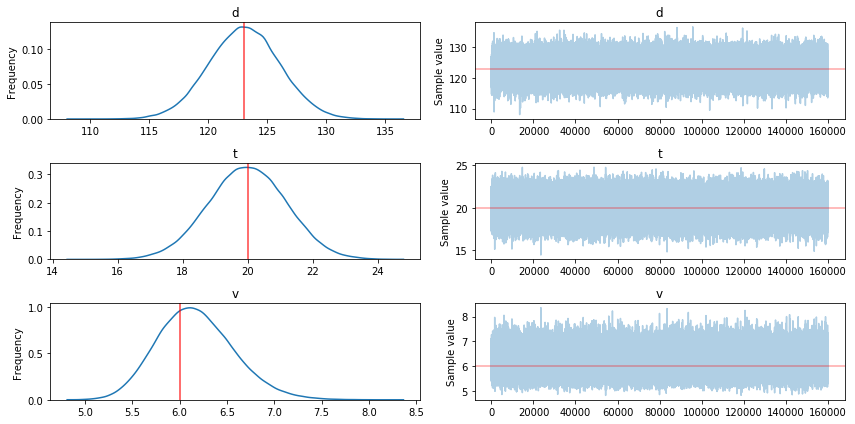

In [28]:
mc.summary(trace)
mc.traceplot(trace, combined=True, lines={'d':123, 't':20, 'v':6})
print("MCMC gives {0:.2f}, analytic gives {1}".format(trace['v'].std(), 0.39))

## Example 3

Example: the period of an oscillation is measured to be T = 0.20 ± 0.01 s. Thus the frequency is
f = 1/T = 5 Hz. What is the uncertainty in f? Answer: the percent uncertainty in T was 0.01/0.20 = 5%.
Thus the percent uncertainty in f is also 5%, which means that δf = 0.25 Hz. So f = 5.0 ± 0.3 Hz (after
rounding).

f = 5.0 ± 0.3 Hz

In [31]:
T = mc.Normal('T', 0.20, (0.01)**-2)

@mc.deterministic()
def f(T=T):
    return 1/T

model = mc.MCMC((T, f))

In [32]:
model.sample(1e4, burn=100, burn_till_tuned=True)

 [-----------------100%-----------------] 14900 of 14900 complete in 0.7 sec

In [33]:
print(f.summary())
print("MCMC gives {0:.1f} +/- {1:.1f}, analytic gives {2} +/- {3}".format(np.mean(f.trace()), np.std(f.trace()), 
                                                                          5.0, 0.3))



f:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	5.013            0.253            0.003              [ 4.52  5.5 ]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	4.554            4.836           5.0            5.177         5.553
	
None
MCMC gives 5.0 +/- 0.3, analytic gives 5.0 +/- 0.3


/Users/blarsen/miniconda3/envs/python3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:225: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)


## Example 4

Example: a ball is tossed straight up into the air with initial speed v0 = 4.0 ± 0.2 m/s. After a time
t = 0.60±0.06 s, the height of the ball is y = v0t−
1
2
gt2 = 0.636 m. What is the uncertainty of y? Assume
g = 9.80 m/s2
(no uncertainty in g).

Thus y would be properly reported as 0.6 ± 0.4 m.

In [35]:
g = 9.80
t = mc.Normal('t', 0.60, (0.06)**-2)
v0 = mc.Normal('v0', 4.0, (0.2)**-2)

@mc.deterministic()
def h(t=t, v0=v0):
    return v0*t - 0.5*g*t**2

model = mc.MCMC((t, v0, h))



In [39]:
model.sample(1e5, burn=100, burn_till_tuned=True)

 [-----------------100%-----------------] 104900 of 104900 complete in 7.6 sec

In [43]:
print(h.summary())
print("MCMC gives {0:.1f} +/- {1:.1f}, analytic gives {2} +/- {3}".format(np.mean(h.trace()), np.std(h.trace()), 
                                                                          0.6, 0.4))



h:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	0.618            0.168            0.0              [ 0.28   0.928]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	0.25             0.515           0.633          0.736         0.907
	
None
MCMC gives 0.6 +/- 0.2, analytic gives 0.6 +/- 0.4


/Users/blarsen/miniconda3/envs/python3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:225: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)


## Example 5
For example, suppose Ann and Billy both measure the speed of a moving ball. Ann measures 3.6±0.2 m/s
and Billy gets 3.3 ± 0.3 m/s. Do the two measurements agree?

D = 0.3 ± 0.4 m/s  so 0 is in the range, they do agree.

In [46]:
A = mc.Normal('A', 3.6, (0.2)**-2)
B = mc.Normal('B', 3.3, (0.3)**-2)

@mc.deterministic()
def D(A=A, B=B):
    return A-B

model = mc.MCMC((A, B, D))

In [47]:
model.sample(1e5, burn=100, burn_till_tuned=True)

 [-----------------100%-----------------] 104900 of 104900 complete in 7.4 sec

In [48]:
print(D.summary())
print("MCMC gives {0:.1f} +/- {1:.1f}, analytic gives {2} +/- {3}".format(np.mean(D.trace()), np.std(D.trace()), 
                                                                          0.3, 0.4))
# mc.Matplot.plot(model)


D:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	0.299            0.361            0.001            [-0.408  1.011]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	-0.412           0.055           0.3            0.542         1.007
	
None
MCMC gives 0.3 +/- 0.4, analytic gives 0.3 +/- 0.4


/Users/blarsen/miniconda3/envs/python3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:225: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)
